# Reset variables and imports

```
pip install pandas

```

In [9]:
%reset -f
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lib.plothelpers import plot_comparison
from lib.mritools import load_dicom_data
from lib.mritools import load_dicom_metadata

In [10]:
datasets = {
    "full_body": {
        "dicom_folder": "./data/wetransfer_59320363_2024-05-23_1500/",
        "output_folder": "data"
    }
}

# Choose dataset
dataset_name = "full_body"  # Change to "preop" to switch datasets

# Load selected dataset
dicom_folder = datasets[dataset_name]["dicom_folder"]
output_folder = datasets[dataset_name]["output_folder"]

print(f"Using {dataset_name} dataset: {dicom_folder}")


Using full_body dataset: ./data/wetransfer_59320363_2024-05-23_1500/


### Investigating a Single MRI DICOM File

In [11]:

slices = []
filename = sorted(os.listdir(dicom_folder))[1]  
filepath = os.path.join(dicom_folder, filename)
ds = pydicom.dcmread(filepath)

print(np.shape(ds.pixel_array))
print(ds.NumberOfFrames)

(5, 192, 192)
5


Unlike CT scans, which usually store one slice per DICOM file, MRI often stores multiple slices in a single file which corresponds with a **scan sequence**: This is a set of images taken with the same settings to focus on specific tissues.

Here, the shape `(5, 192, 192)` means the file contains **5 image slices**, each **192×192** pixels.  
We confirmed this using the DICOM tag `NumberOfFrames`, which returned **5**.

This multi-frame format is common in MRI, especially with modern scanners, though some setups still use one file per slice.


# Create table of most interesting DICOM datasets

The most important difference is that to create our volume .nrrd datasets we no longer need multiple DICOM files. Each DICOM file is no a standalone dataset that can be converted to a volumetric .nrrd file. 

We will inspect each DICOM file and store information about it like the shape, name, number of slices in a table. This way we can process the most important ones later.

In [12]:
# Load DICOM metadata into a DataFrame
dicom_metadata_df = load_dicom_metadata(dicom_folder)
dicom_metadata_df.head(5)

,filename,num_slices,shape,modality,study_date
0,59320363,16,"(16, 192, 192)",MR,20230913
1,59320374,5,"(5, 192, 192)",MR,20230913
2,59320550,13,"(13, 192, 192)",MR,20230913
3,59320561,5,"(5, 192, 192)",MR,20230913
4,59320572,13,"(13, 192, 192)",MR,20230913


#### Sort by amount of voxels in scan

This can be calculated by multiplying the amount of slices in a sequence by the dimensions of one image. 

In [13]:
dicom_metadata_df["voxel_count"] = dicom_metadata_df["shape"].apply(
    lambda s: np.prod(s)
)

dicom_metadata_df.sort_values(by="voxel_count", ascending=False, inplace=True)
top_datasets = dicom_metadata_df.head(5)

# Print the metadata of the top N datasets
top_datasets

,filename,num_slices,shape,modality,study_date,voxel_count
63,59321221,236,"(236, 192, 256)",MR,20230913,11599872
62,59321210,236,"(236, 192, 256)",MR,20230913,11599872
61,59321199,236,"(236, 192, 256)",MR,20230913,11599872
64,59321232,236,"(236, 192, 256)",MR,20230913,11599872
103,59321661,88,"(88, 264, 352)",MR,20230913,8177664


In [14]:
file_name = '59321199' # beste voor spieren
dicom_data = load_dicom_data(dicom_folder, file_name)
print(dicom_data.shape)


(236, 192, 256)


### Saving the sequences

This MRI dataset has some quirks:

- All sequences appear flipped vertically in the visualizer.
- The resolution between slices (vertical direction) is half the resolution within each slice (sagittal plane), so effectively half of the slices are missing.

We will need to correct these issues before saving.

In [15]:
vertical_scaling = 2  # Example: 2 means each row is duplicated twice

for file_name in top_datasets['filename']:
    dicom_data = load_dicom_data(dicom_folder, file_name)
    
    # Invert along vertical axis
    dicom_data = np.flip(dicom_data, axis=0)

    # Apply vertical scaling
    dicom_data_scaled = np.repeat(dicom_data, vertical_scaling, axis=0)
    
    # Save the NumPy array
    output_path = os.path.join(output_folder, f"mri_{file_name}.npy")
    np.save(output_path, dicom_data_scaled)

    print(f"Saved {output_path}")


Saved data\mri_59321221.npy
Saved data\mri_59321210.npy
Saved data\mri_59321199.npy
Saved data\mri_59321232.npy
Saved data\mri_59321661.npy


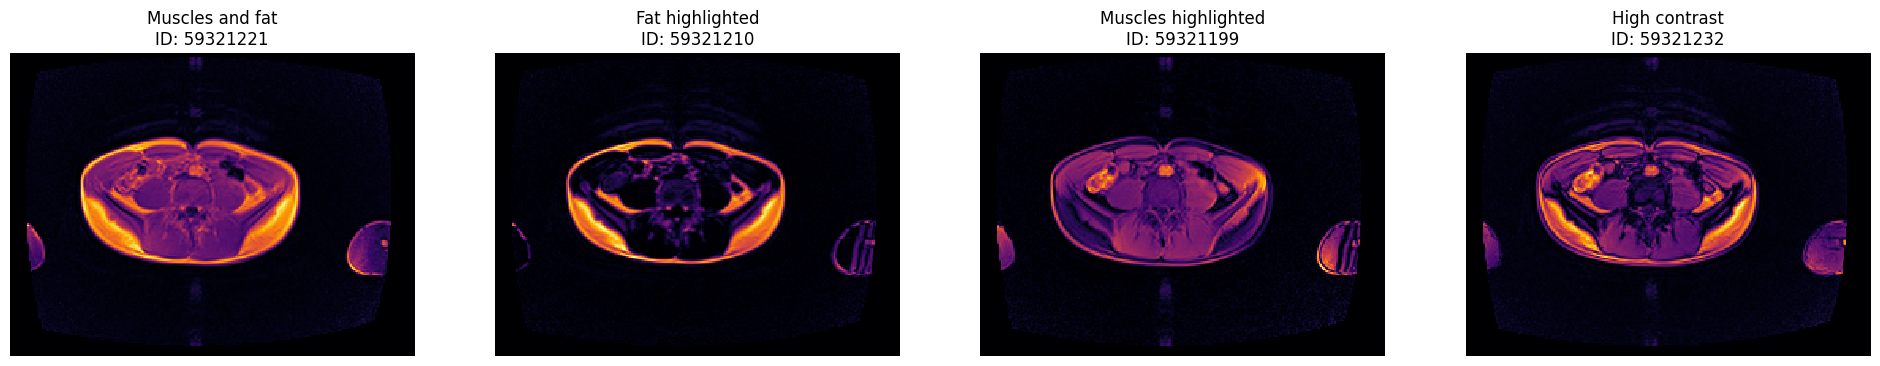

In [16]:
slice_index = 0

# List of (label, study UID) tuples
studies = [
    ("Muscles and fat", "59321221"),
    ("Fat highlighted", "59321210"),
    ("Muscles highlighted", "59321199"),
    ("High contrast", "59321232"),    
]

images = []
titles = []
for label, study_uid in studies:
    dicom_data = load_dicom_data(dicom_folder, study_uid)
    images.append(dicom_data[slice_index])
    titles.append(f"{label}\nID: {study_uid}")

plot_comparison(images, titles)